In [2]:
import pandas as pd
import numpy as np

# Load wallets
wallets_df = pd.read_csv("wallets.csv")
wallets_df.head()

,wallet_id
0,0x0039f22efb07a647557c7c5d17854cfd6d489ef3
1,0x06b51c6882b27cb05e712185531c1f74996dd988
2,0x0795732aacc448030ef374374eaae57d2965c16c
3,0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9
4,0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae


In [3]:
# For simplicity, simulate behavior
np.random.seed(42)

wallets_df["total_supplied"] = np.random.uniform(100, 50000, size=len(wallets_df))
wallets_df["total_borrowed"] = np.random.uniform(0, 40000, size=len(wallets_df))
wallets_df["liquidations_count"] = np.random.randint(0, 5, size=len(wallets_df))
wallets_df["repayment_ratio"] = np.random.uniform(0.3, 1.0, size=len(wallets_df))
wallets_df["avg_borrow_duration"] = np.random.uniform(5, 120, size=len(wallets_df))  # in days


In [4]:
wallets_df["net_balance"] = wallets_df["total_supplied"] - wallets_df["total_borrowed"]
wallets_df["supply_borrow_ratio"] = (
    wallets_df["total_supplied"] / (wallets_df["total_borrowed"] + 1)  # +1 to avoid division by zero
)


In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

features_to_normalize = [
    "total_supplied",
    "total_borrowed",
    "net_balance",
    "liquidations_count",
    "repayment_ratio",
    "avg_borrow_duration",
    "supply_borrow_ratio"
]

wallets_df[[f + "_norm" for f in features_to_normalize]] = scaler.fit_transform(wallets_df[features_to_normalize])


In [6]:
# Define weights (customizable)
weights = {
    "total_supplied_norm": 0.2,
    "total_borrowed_norm": -0.3,
    "net_balance_norm": 0.2,
    "liquidations_count_norm": -0.2,
    "repayment_ratio_norm": 0.3,
    "avg_borrow_duration_norm": -0.1,
    "supply_borrow_ratio_norm": 0.1
}

# Weighted sum
wallets_df["score_raw"] = sum(
    wallets_df[f] * w for f, w in weights.items()
)

# Rescale scores to 0–1000
wallets_df["score"] = MinMaxScaler(feature_range=(0, 1000)).fit_transform(wallets_df[["score_raw"]])


In [7]:
wallets_df[["wallet_id", "score"]].to_csv("wallet_scores.csv", index=False)


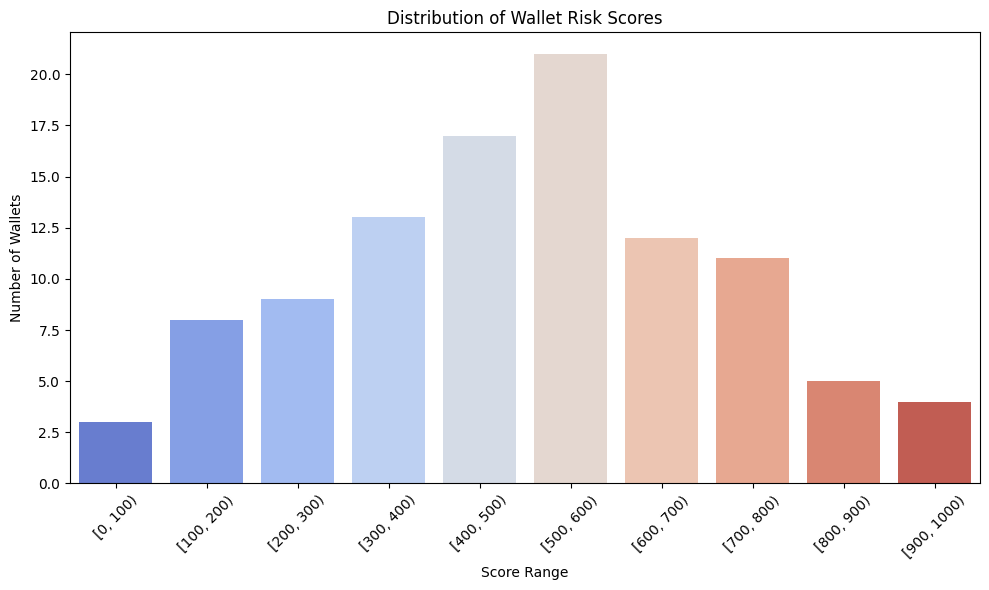

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define score buckets
wallets_df["score_range"] = pd.cut(
    wallets_df["score"],
    bins=[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    right=False
)

plt.figure(figsize=(10, 6))
sns.countplot(data=wallets_df, x="score_range", palette="coolwarm")
plt.title("Distribution of Wallet Risk Scores")
plt.xlabel("Score Range")
plt.ylabel("Number of Wallets")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
